## Is it a bird?

In [64]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [65]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai

In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

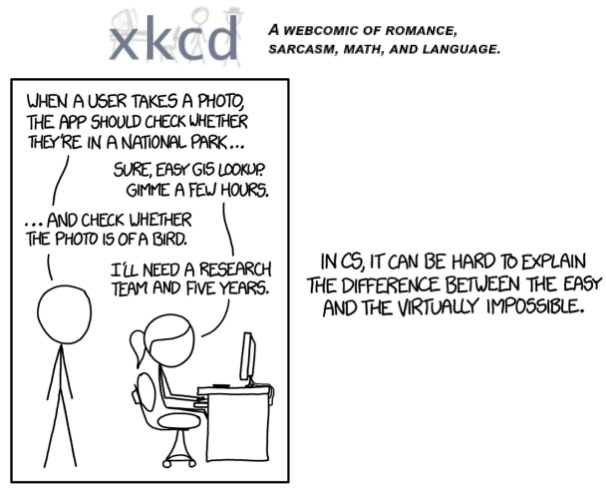

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of birds and non-birds

In [67]:
# Skip this cell if you already have duckduckgo_search installed
!pip install -Uqq duckduckgo_search

In [75]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [76]:
??L().itemgot

Object `L().itemgot` not found.


Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [77]:
urls = search_images('bird photos', max_images=1)
urls[0]

'https://www.almanac.com/sites/default/files/image_nodes/bluebird-3456115_1920.jpg'

In [78]:
doc(download_url)

...and then download a URL and take a look at it:

In [ ]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Signature: im.to_thumb(h, w=None)
Source:   
@patch
def to_thumb(self:Image.Image, h, w=None):
    "Same as `thumbnail`, but uses a copy"
    if w is None: w=h
    im = self.copy()
    im.thumbnail((w,h))
    return im
File:      ~/.local/lib/python3.9/site-packages/fastai/vision/core.py
Type:      method


In [85]:
??im.thumbnail

Signature: im.thumbnail(size, resample=<Resampling.BICUBIC: 3>, reducing_gap=2.0)
Source:   
    def thumbnail(self, size, resample=Resampling.BICUBIC, reducing_gap=2.0):
        """
        Make this image into a thumbnail.  This method modifies the
        image to contain a thumbnail version of itself, no larger than
        the given size.  This method calculates an appropriate thumbnail
        size to preserve the aspect of the image, calls the
        :py:meth:`~PIL.Image.Image.draft` method to configure the file reader
        (where applicable), and finally resizes the image.

        Note that this function modifies the :py:class:`~PIL.Image.Image`
        object in place.  If you need to use the full resolution image as well,
        apply this method to a :py:meth:`~PIL.Image.Image.copy` of the original
        image.

        :param size: Requested size.
        :param resample: Optional resampling filter.  This can be one
           of :py:data:`PIL.Image.Resampling.NEARE

Now let's do the same with "forest photos":

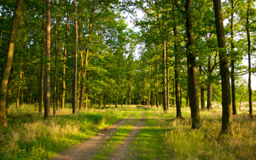

In [ ]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab 200 examples of each of "bird" and "forest" photos, and save each group of photos to a different folder:

In [88]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.9/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.9/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.9/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


In [90]:
??path.mkdir

Signature: path.mkdir(mode=511, parents=False, exist_ok=False)
Source:   
    def mkdir(self, mode=0o777, parents=False, exist_ok=False):
        """
        Create a new directory at this given path.
        """
        try:
            self._accessor.mkdir(self, mode)
        except FileNotFoundError:
            if not parents or self.parent == self:
                raise
            self.parent.mkdir(parents=True, exist_ok=True)
            self.mkdir(mode, parents=False, exist_ok=exist_ok)
        except OSError:
            # Cannot rely on checking for EEXIST, since the operating system
            # could give priority to other errors like EACCES or EROFS
            if not exist_ok or not self.is_dir():
                raise
File:      /usr/lib/python3.9/pathlib.py
Type:      method


In [91]:
??resize_images

Signature:
resize_images(
    path,
    max_workers=8,
    max_size=None,
    recurse=False,
    dest=Path('.'),
    n_channels=3,
    ext=None,
    img_format=None,
    resample=<Resampling.BILINEAR: 2>,
    resume=None,
    **kwargs,
)
Source:   
def resize_images(path, max_workers=defaults.cpus, max_size=None, recurse=False,
                  dest=Path('.'), n_channels=3, ext=None, img_format=None, resample=BILINEAR,
                  resume=None, **kwargs):
    "Resize files on path recursively to dest to max_size"
    path = Path(path)
    if resume is None and dest != Path('.'): resume=False
    os.makedirs(dest, exist_ok=True)
    files = get_image_files(path, recurse=recurse)
    files = [o.relative_to(path) for o in files]
    parallel(resize_image, files, src=path, n_workers=max_workers, max_size=max_size, dest=dest, n_channels=n_channels, ext=ext,
                   img_format=img_format, resample=resample, resume=resume, **kwargs)
File:      ~/.local/lib/python3.9/site-pack

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

In [94]:
??verify_images

Signature: verify_images(fns)
Source:   
def verify_images(fns):
    "Find images in `fns` that can't be opened"
    return L(fns[i] for i,o in enumerate(parallel(verify_image, fns)) if not o)
File:      ~/.local/lib/python3.9/site-packages/fastai/vision/utils.py
Type:      function


In [95]:
??Path.unlink

Signature: Path.unlink(self, missing_ok=False)
Source:   
    def unlink(self, missing_ok=False):
        """
        Remove this file or link.
        If the path is a directory, use rmdir() instead.
        """
        try:
            self._accessor.unlink(self)
        except FileNotFoundError:
            if not missing_ok:
                raise
File:      /usr/lib/python3.9/pathlib.py
Type:      function


In [96]:
path.ls()

(#2) [Path('bird_or_not/forest'),Path('bird_or_not/bird')]

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

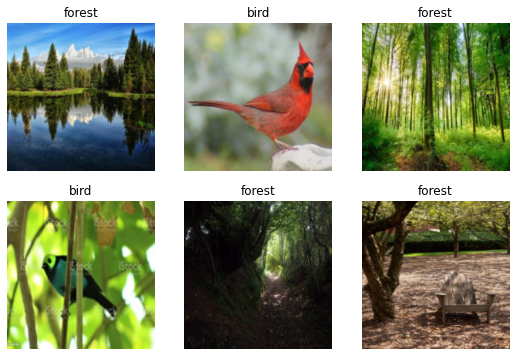

In [97]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.606847,0.776637,0.240000,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.114463,0.045450,0.026667,00:03
1,0.065541,0.009315,0.000000,00:02
2,0.043300,0.007967,0.000000,00:02


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [ ]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.